In [15]:
!pip install catboost

In [16]:
#Importing necessary libraries
import sklearn.metrics as metrics
import datetime
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from requests import get
import math
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [17]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [18]:
#Reading the data file
df = pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Independent_Study/Depression_Study/updatedData2.xlsx")
#Creating a copy
df_copy = df

In [19]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 98 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Y1PPTID                 1024 non-null   int64  
 1   Y1IL6                   985 non-null    float64
 2   Y1CRP                   985 non-null    float64
 3   Y1TNFa                  985 non-null    float64
 4   Y1MCP1                  985 non-null    float64
 5   Y1PTX3                  986 non-null    float64
 6   osteopontin             985 non-null    float64
 7   ngal                    985 non-null    float64
 8   ngalplasmaspecific      985 non-null    float64
 9   st2                     985 non-null    float64
 10  galectin3               985 non-null    float64
 11  gdf15                   985 non-null    float64
 12  Y1Leptin                985 non-null    float64
 13  Y1Insulin               984 non-null    float64
 14  Y1MICROALBUMIN          927 non-null    

## Data pre-processing

1. Checking for duplicate data

In [20]:
print(df.duplicated().any())

False


2. Checking for negative data

In [21]:
#Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number])
# Find negative values
negatives = (numeric_cols < 0).sum()
negatives = negatives[negatives > 0]  # Only keep columns with negatives
# Print or view the result
print("Columns with negative values:")
print(negatives)

Columns with negative values:
Series([], dtype: int64)


3. There are no datatype inconsistencies

## Handling missing data

In [22]:
def check_missing_info(df, sort=True, show_only_missing=True):
    """
    Returns a DataFrame showing missing counts and percentages for each column.
    """
    missing_info = df.isnull().sum()
    missing_percent = 100 * df.isnull().mean()
    result = pd.DataFrame({
        'missing_count': missing_info,
        'missing_percent': missing_percent
    })
    if show_only_missing:
        result = result[result['missing_count'] > 0]
    if sort:
        result = result.sort_values(by='missing_count', ascending=False)

    print(f"Total features with missing data: {result.shape[0]}")
    return result

In [23]:
check_missing_info(df)

Total features with missing data: 85


,missing_count,missing_percent
DP4RC,524,51.172
Y1PlasmaDopamine,203,19.824
Y1PlasmaEPI,194,18.945
Y1PlasmaNOREPI,194,18.945
Y1URCORT,136,13.281
Y1PhosphorusUR,120,11.719
Y1CalciumUR,120,11.719
gdf11,119,11.621
Y1microalb_creat_ratio,97,9.473
Y1MICROALBUMIN,97,9.473


In [24]:
#Dropping the features with over 10% data missing and id feature as it recognises the data
df.drop(['Y1PPTID', 'DP4RC', 'Y1PlasmaDopamine', 'Y1PlasmaEPI', 'Y1PlasmaNOREPI', 'Y1URCORT', 'Y1PhosphorusUR', 'Y1CalciumUR', 'gdf11'], axis=1, inplace=True)

In [25]:
#Checking the features that are left
check_missing_info(df)

Total features with missing data: 77


,missing_count,missing_percent
Y1MICROALBUMIN,97,9.473
Y1microalb_creat_ratio,97,9.473
Y1Pt_eGFR_CystC_calc,72,7.031
Y1Telomere_UCSF,70,6.836
Y1EPI,62,6.055
Y1DOP,61,5.957
Y1NOREPI,58,5.664
Y1CREAUR,57,5.566
Y1URCREA_ORIG,57,5.566
Y1FetuinA,55,5.371


In [26]:
#Dropping the row in which target variable is NaN
df.dropna(subset=['PHQ'], inplace=True)

In [27]:
df.shape

(1023, 89)

In [28]:
#Scaling the data into 0-1
X = df.drop(['PHQ'], axis=1)
y = df['PHQ']
#Splitting the data set into 70% training and 30% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

1. Leave Missing Values As-Is

In [29]:
#Running baseline models to check performance with missing data
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

models = {
    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function="Logloss",
        eval_metric="AUC",
        verbose=0
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        eval_metric="logloss",
        use_label_encoder=False
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_iter=500,
        learning_rate=0.05
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

results_df = pd.DataFrame(results).set_index("Model").sort_values("ROC AUC", ascending=False)
results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 155, number of negative: 612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12422
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202086 -> initscore=-1.373307
[LightGBM] [Info] Start training from score -1.373307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:02:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,ROC AUC,PR AUC
Model,,,,,,,,,,,,
CatBoost,10,8,205,33,0.840,0.556,0.233,0.962,0.328,0.038,0.809,0.504
LightGBM,10,9,204,33,0.836,0.526,0.233,0.958,0.323,0.042,0.740,0.404
HistGradientBoosting,10,10,203,33,0.832,0.500,0.233,0.953,0.317,0.047,0.738,0.423
XGBoost,8,16,197,35,0.801,0.333,0.186,0.925,0.239,0.075,0.736,0.390


From here, we can see that missing data needs to be handled as well as there is a data imbalance issue. The best performing algorithm -> CatBoost will be used for further experimentation.

2. Median Imputation with Missing Indicator flags

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)

# Models to run
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=500),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

results_df_median = pd.DataFrame(results).set_index("Model").sort_values("ROC AUC", ascending=False)
results_df_median


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,ROC AUC,PR AUC
Model,,,,,,,,,,,,
RandomForest,2,3,210,41,0.828,0.400,0.047,0.986,0.083,0.014,0.787,0.467
LogisticRegression,11,9,204,32,0.840,0.550,0.256,0.958,0.349,0.042,0.661,0.384
MLP,15,57,156,28,0.668,0.208,0.349,0.732,0.261,0.268,0.566,0.216


3. Trying KNN Imputation strategy


In [31]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

results_knn = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("imputer", KNNImputer(n_neighbors=6)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results_knn.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

results_df_knn = pd.DataFrame(results_knn).set_index("Model").sort_values("ROC AUC", ascending=False)
results_df_knn


,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,ROC AUC,PR AUC
Model,,,,,,,,,,,,
RandomForest,3,4,209,40,0.828,0.429,0.070,0.981,0.120,0.019,0.783,0.462
LogisticRegression,16,14,199,27,0.840,0.533,0.372,0.934,0.438,0.066,0.729,0.487
MLP,17,25,188,26,0.801,0.405,0.395,0.883,0.400,0.117,0.695,0.405


4. MICE

In [32]:
from sklearn.experimental import enable_iterative_imputer  # needed to enable IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)

# Models to run
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=500),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500)
}

# Iterative Imputer (MICE)
imputer = IterativeImputer(random_state=42, max_iter=10, sample_posterior=True)

results_mice = []

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("imputer", imputer),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results_mice.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    })

results_df_mice = pd.DataFrame(results_mice).set_index("Model").sort_values("ROC AUC", ascending=False)
results_df_mice


,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,ROC AUC,PR AUC
Model,,,,,,,,,,,,
RandomForest,5,2,211,38,0.844,0.714,0.116,0.991,0.200,0.009,0.769,0.430
LogisticRegression,17,16,197,26,0.836,0.515,0.395,0.925,0.447,0.075,0.717,0.439
MLP,16,24,189,27,0.801,0.400,0.372,0.887,0.386,0.113,0.641,0.352


We can see a couple of things from this experimentation.

1. There is a class imbalance in the dataset.
2. The best performing algorithms are CatBoost and Random Forest.
3. Imputation is not having much of a difference in the performance.
4. Best strategy is to leave the missing data as it is because these are biomarker data, missing lab values are not random.


## Highly Correlated Features

In [33]:
df.shape

(1023, 89)

<Axes: >

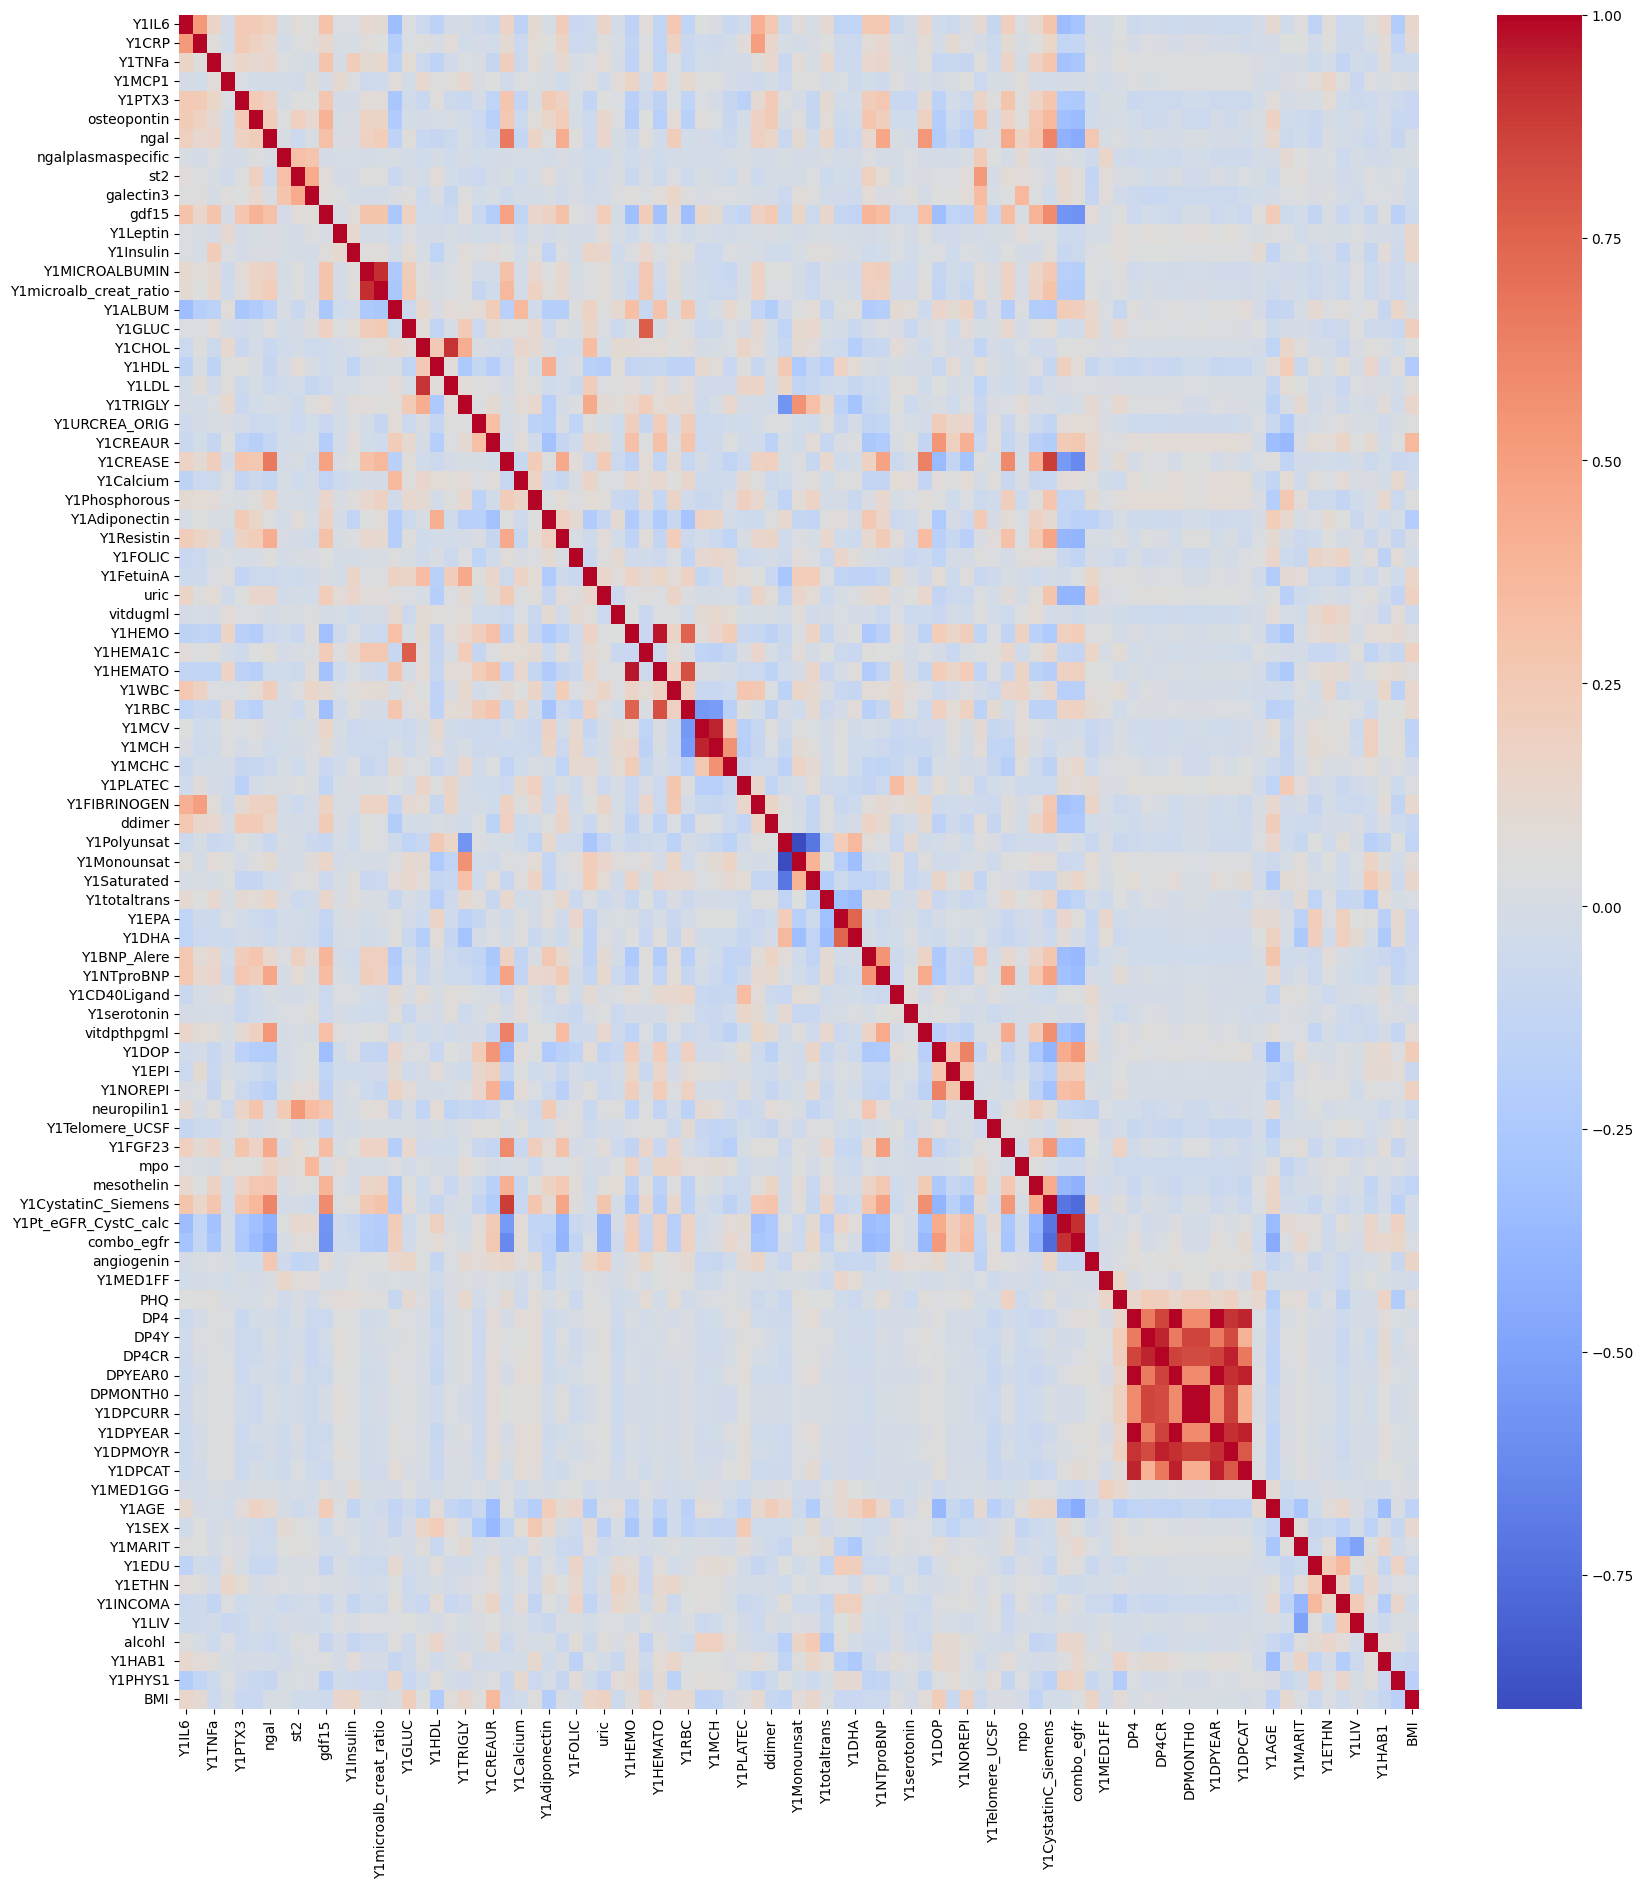

In [34]:
import seaborn as sns
plt.figure(figsize=(20,22))
#Plotting heatmap to understand correlation between variables
sns.heatmap(df.corr(),cmap='coolwarm')

In [36]:
# Select only numeric features (exclude IDs)
numeric_features = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Select upper triangle to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation > 0.8
high_corr_pairs = []
threshold = 0.8
for col in upper.columns:
    for row in upper.index:
        if pd.notna(upper.loc[row, col]) and abs(upper.loc[row, col]) > threshold:
            high_corr_pairs.append({
                'Feature 1': row,
                'Feature 2': col,
                'Correlation': upper.loc[row, col]
            })

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(by='Correlation', ascending=False)

# Display table
print(f"Number of feature pairs with correlation > {threshold*100}%: {high_corr_df.shape[0]}")
high_corr_df


Number of feature pairs with correlation > 80.0%: 30


,Feature 1,Feature 2,Correlation
19,DPYEAR0,Y1DPYEAR,1.000
16,DPMONTH0,Y1DPCURR,1.000
10,DP4,DPYEAR0,0.997
17,DP4,Y1DPYEAR,0.997
2,Y1HEMO,Y1HEMATO,0.968
22,DP4CR,Y1DPMOYR,0.950
28,DPYEAR0,Y1DPCAT,0.949
29,Y1DPYEAR,Y1DPCAT,0.949
27,DP4,Y1DPCAT,0.948
4,Y1MCV,Y1MCH,0.946


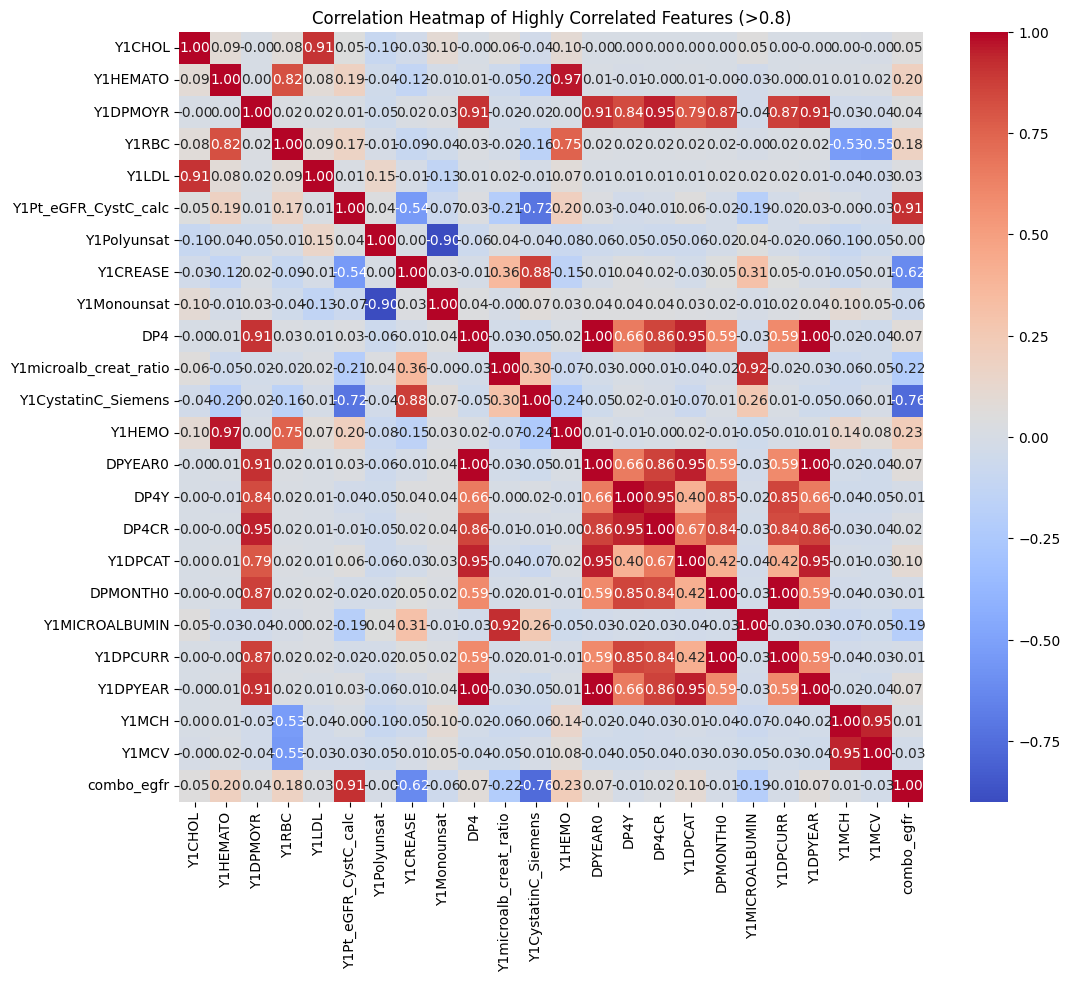

In [37]:
# Get list of features involved in high correlation pairs
features_to_plot = list(set(high_corr_df['Feature 1']).union(set(high_corr_df['Feature 2'])))

# Subset correlation matrix for these features
subset_corr = numeric_features[features_to_plot].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Highly Correlated Features (>0.8)")
plt.show()

In [38]:
#Dropping date time repeated features to remove high correlation.
cols_to_drop1 = ['DP4', 'DP4Y', 'DP4CR', 'DP4CR', 'DPYEAR0', 'DPMONTH0', 'Y1DPMOYR', 'Y1DPCAT']
df.drop(columns=cols_to_drop1, inplace=True)

In [41]:
# Select only numeric features (exclude IDs)
numeric_features = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Select upper triangle to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation > 0.8
high_corr_pairs = []
threshold = 0.8
for col in upper.columns:
    for row in upper.index:
        if pd.notna(upper.loc[row, col]) and abs(upper.loc[row, col]) > threshold:
            high_corr_pairs.append({
                'Feature 1': row,
                'Feature 2': col,
                'Correlation': upper.loc[row, col]
            })

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(by='Correlation', ascending=False)

# Display table
print(f"Number of feature pairs with correlation > {threshold*100}%: {high_corr_df.shape[0]}")
high_corr_df


Number of feature pairs with correlation > 80.0%: 8


,Feature 1,Feature 2,Correlation
2,Y1HEMO,Y1HEMATO,0.968
4,Y1MCV,Y1MCH,0.946
0,Y1MICROALBUMIN,Y1microalb_creat_ratio,0.925
7,Y1Pt_eGFR_CystC_calc,combo_egfr,0.914
1,Y1CHOL,Y1LDL,0.909
6,Y1CREASE,Y1CystatinC_Siemens,0.876
3,Y1HEMATO,Y1RBC,0.818
5,Y1Polyunsat,Y1Monounsat,-0.900



1. Y1HEMO vs Y1HEMATO	0.968	Y1HEMATO	Hematocrit is derived from hemoglobin; keeping hemoglobin is sufficient

2. Y1MCV vs Y1MCH	0.946	Y1MCH	MCH is mean corpuscular hemoglobin; MCV (cell size) is more standard for red cell analysis

3. Y1Polyunsat vs Y1Monounsat	-0.900	Y1Monounsat	Polyunsaturated fatty acids are more biologically relevant; negative correlation indicates redundancy

4. Y1MICROALBUMIN vs Y1microalb_creat_ratio	0.925	Y1MICROALBUMIN	Ratio adjusts for urine creatinine; more informative for kidney function

5. Y1Pt_eGFR_CystC_calc vs combo_egfr	0.914	Y1Pt_eGFR_CystC_calc	combo_egfr is a composite, likely more accurate

6. Y1CREASE vs Y1CystatinC_Siemens	0.876	Y1CREASE	Cystatin C is less affected by muscle mass, more robust for kidney function

7. Y1CHOL vs Y1LDL	0.909	Depends on analysis	For trees, can keep both; for interpretability, total cholesterol may be sufficient

In [42]:
#Dropping other highly correlated pairs
cols_to_drop2 = ['Y1HEMATO', 'Y1MCH', 'Y1Monounsat', 'Y1MICROALBUMIN', 'Y1Pt_eGFR_CystC_calc', 'Y1CREASE']
df.drop(columns=cols_to_drop2, inplace=True)

In [43]:
df.shape

(1023, 76)

<Axes: >

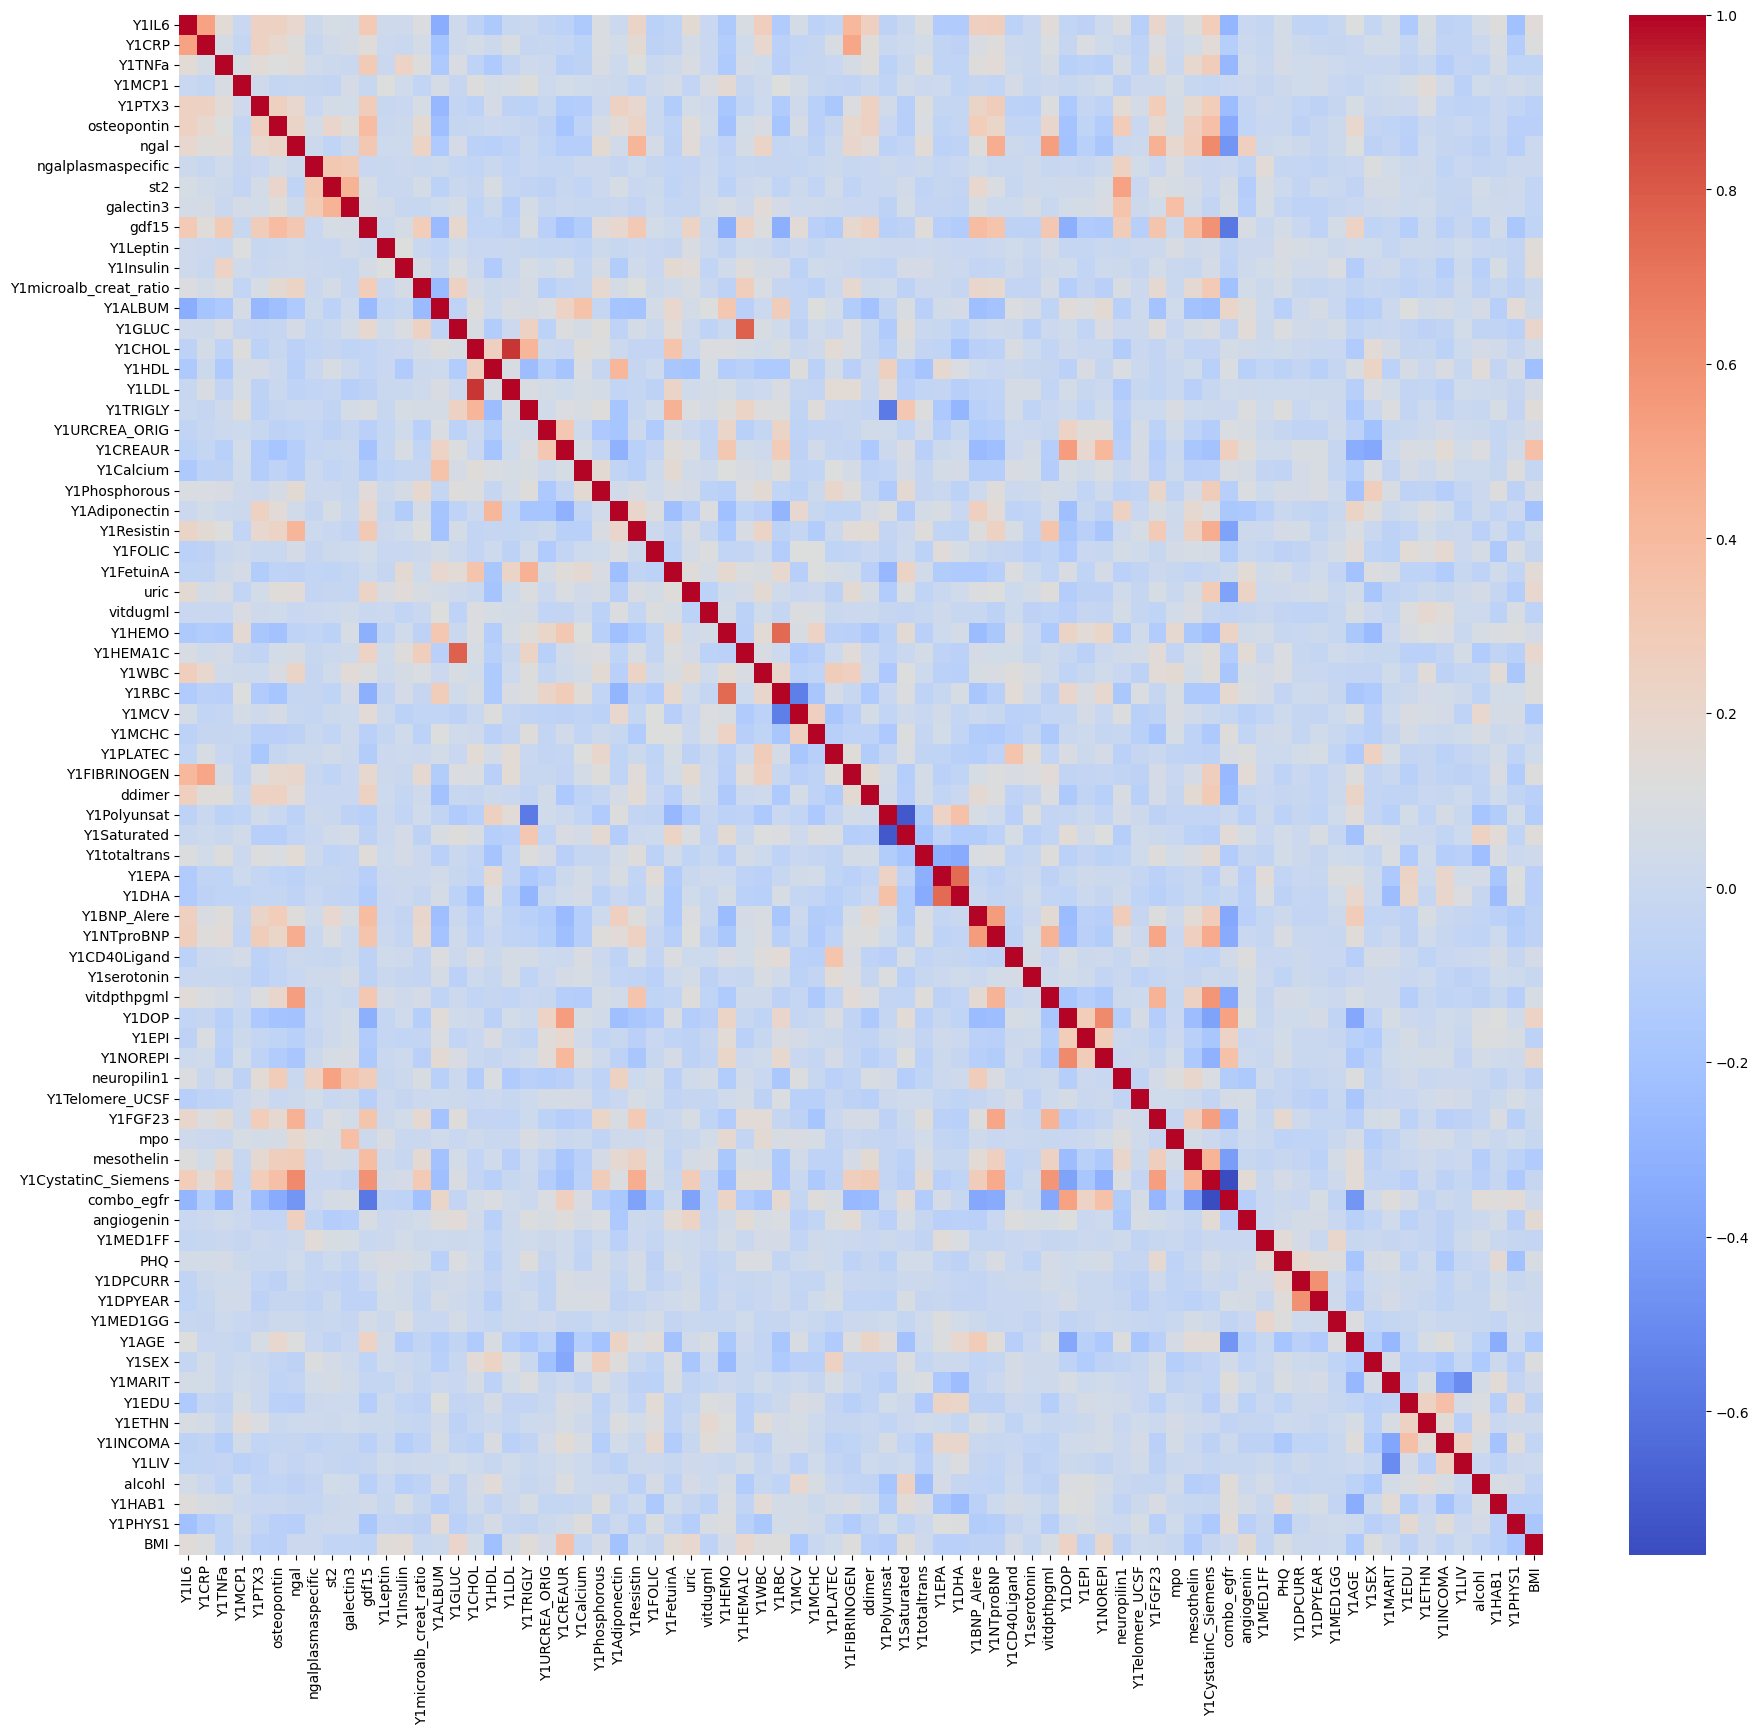

In [44]:
plt.figure(figsize=(22, 20))
#Plotting heatmap to understand correlation between variables
sns.heatmap(df.corr(),cmap='coolwarm')

## Writing the data

In [45]:
df.to_csv("/content/drive/MyDrive/ColabNotebooks/Independent_Study/Depression_Study/preprocessed_depression_study.csv",index=False, header = True)